# Fine-tuned Model Evaluation Report

This report compares multiple models on:
- Syntactic Validity (%): queries passing custom syntax validation
- Execution Success (%): queries executing without errors
- Output Accuracy (%): queries returning the correct answer
- Average Latency (ms): average time to generate output
- Token Usage: average input/output tokens per query

Notes:
- Latency for Qwen models is constrained by GPU inference, there is room for optimization.
- Display names are normalized for readability. Raw model IDs remain available in the underlying data.

The sections below are:
1) Accuracy metrics across models
2) Qwen3-4B: before vs after fine-tuning
3) Overall output accuracy
4) Latency by model
5) Token usage per query
6) Accuracy vs latency trade-off
7) Model links

Highlights:
- Fine tuned SLMs gave 2x improvement in output accuracy over general, more powerful Gemini models, while also being faster.
- Qwen3-4B (ft-oncograph) displayed 100% syntactic validity and execution success.
- Gemini-2.5-Flash showed slightly worse output accuracy than Gemini-2.0-Flash, despite taking more time.

In [1]:
# Setup and styling
from __future__ import annotations

import json
from pathlib import Path
from typing import Any

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from IPython.display import Markdown, display
from matplotlib import cycler, ticker

# Matplotlib/Seaborn style
sns.set_theme(style="whitegrid")
plt.rcParams["figure.figsize"] = (12, 6)
plt.rcParams["axes.titleweight"] = "bold"
plt.rcParams["axes.labelweight"] = "bold"
plt.rcParams["axes.titlelocation"] = "left"
plt.rcParams["axes.grid"] = True
plt.rcParams["grid.alpha"] = 0.3

# Unified color palette
PALETTE = [
    "#4C78A8",  # blue
    "#F58518",  # orange
    "#54A24B",  # green
    "#E45756",  # red
    "#72B7B2",  # teal
    "#B279A2",  # purple
    "#FF9DA6",  # pink
]
plt.rcParams["axes.prop_cycle"] = cycler(color=PALETTE)

In [2]:
# Data loading and transformation
def find_results_dir() -> Path:
    """
    Resolve evaluation results directory.
    Tries common locations relative to the notebook/script.
    """
    candidates = [
        Path.cwd() / "evaluation" / "results",
        Path.cwd().parent / "evaluation" / "results",
        Path.cwd() / "results",
    ]
    for p in candidates:
        if p.exists() and p.is_dir():
            return p
    raise FileNotFoundError(
        "Could not find an 'evaluation/results' directory. "
        "Please ensure JSON files exist at one of these paths: "
        f"{', '.join(str(c) for c in candidates)}"
    )


def load_evaluation_results(results_dir: Path) -> dict[str, dict[str, Any]]:
    """
    Load all *_evaluation_results.json files and return
    { raw_model_name: metrics_plus_metadata }
    """
    files = sorted(results_dir.glob("*_evaluation_results.json"))
    if not files:
        raise FileNotFoundError(f"No '*_evaluation_results.json' files found in {results_dir}")

    all_results: dict[str, dict[str, Any]] = {}
    for result_file in files:
        model_name = result_file.stem.replace("_evaluation_results", "")
        with result_file.open("r", encoding="utf-8") as f:
            data = json.load(f)

        # Try multiple expected schemas gracefully
        metrics = {}
        if isinstance(data, dict):
            if "models" in data and model_name in data.get("models", {}):
                metrics = data["models"][model_name].get("metrics", {})
            elif "metrics" in data:
                metrics = data["metrics"]

        # Attach common metadata if present
        metrics["timestamp"] = data.get("timestamp", "")
        metrics["test_set_size"] = data.get("test_set_size", 0)
        all_results[model_name] = metrics

    return all_results


def create_comparison_dataframe(results: dict[str, dict[str, Any]]) -> pd.DataFrame:
    """
    Build a DataFrame with nicely named columns and normalized display model names.
    """
    name_aliases = {
        "qwen3-4b-it-2507-trained": "Qwen3-4B (ft-oncograph)",
        "qwen3-4b-it-2507-base": "Qwen3-4B (base)",
        "qwen3-1.7b-trained": "Qwen3-1.7B (ft-oncograph)",
        "gemini-2.0-flash": "Gemini 2.0 Flash",
        "gemini-2.5-flash": "Gemini 2.5 Flash",
        "gemini-2.5-flash-lite": "Gemini 2.5 Flash Lite",
    }

    rows: list[dict[str, Any]] = []
    for raw_model, m in results.items():
        display_name = name_aliases.get(raw_model, raw_model)
        rows.append(
            {
                "Raw Model": raw_model,
                "Model": display_name,
                "Syntactic Validity (%)": float(m.get("syntactic_validity_pct", 0.0)),
                "Execution Success (%)": float(m.get("execution_success_pct", 0.0)),
                "Output Accuracy (%)": float(m.get("output_accuracy_pct", 0.0)),
                "Avg Latency (ms)": float(m.get("avg_latency_ms", 0.0)),
                "Avg Input Tokens": float(m.get("avg_input_tokens", 0.0)),
                "Avg Output Tokens": float(m.get("avg_output_tokens", 0.0)),
                "Total Input Tokens": int(m.get("total_input_tokens", 0)),
                "Total Output Tokens": int(m.get("total_output_tokens", 0)),
                "Test Set Size": int(m.get("test_set_size", m.get("total", 0))),
                "Timestamp": m.get("timestamp", ""),
            }
        )

    df = pd.DataFrame(rows)
    if not df.empty and "Output Accuracy (%)" in df.columns:
        df = df.sort_values("Output Accuracy (%)", ascending=False)
    return df

In [3]:
# Plot helpers
def _bar_label(ax: plt.Axes, bars, fmt: str, pad: int = 4, fontsize: int = 9):
    """
    Add labels on top of bars with a consistent format.
    """
    try:
        ax.bar_label(bars, fmt=fmt, padding=pad, fontsize=fontsize)
    except Exception:
        for bar in bars:
            height = bar.get_height()
            ax.text(
                bar.get_x() + bar.get_width() / 2.0,
                height,
                fmt % height,
                ha="center",
                va="bottom",
                fontsize=fontsize,
            )


def _percent_axis(ax: plt.Axes):
    ax.set_ylim(0, 110)
    ax.yaxis.set_major_formatter(ticker.PercentFormatter(xmax=100))


def plot_accuracy_metrics(df: pd.DataFrame, exclude_raw: list[str] | None = None):
    """
    Grouped bars: Syntactic Validity, Execution Success, Output Accuracy.
    """
    data = df.copy()
    if exclude_raw:
        data = data[~data["Raw Model"].isin(exclude_raw)]

    if data.empty:
        display(Markdown("No data available for accuracy metrics."))
        return

    x = range(len(data))
    width = 0.25

    fig, ax = plt.subplots(figsize=(12, 6))
    bars1 = ax.bar(
        [i - width for i in x],
        data["Syntactic Validity (%)"],
        width,
        label="Syntactic Validity",
        alpha=0.85,
        color=PALETTE[0],
    )
    bars2 = ax.bar(
        x,
        data["Execution Success (%)"],
        width,
        label="Execution Success",
        alpha=0.85,
        color=PALETTE[1],
    )
    bars3 = ax.bar(
        [i + width for i in x],
        data["Output Accuracy (%)"],
        width,
        label="Output Accuracy",
        alpha=0.85,
        color=PALETTE[2],
    )

    ax.set_title("Accuracy Metrics Across Models")
    ax.set_xlabel("Model")
    ax.set_ylabel("Percentage")
    ax.set_xticks(list(x))
    ax.set_xticklabels(data["Model"], rotation=45, ha="right")

    _percent_axis(ax)
    ax.legend(loc="upper right")
    _bar_label(ax, bars1, fmt="%.1f%%")
    _bar_label(ax, bars2, fmt="%.1f%%")
    _bar_label(ax, bars3, fmt="%.1f%%")
    plt.tight_layout()
    plt.show()


def plot_qwen_before_after(df: pd.DataFrame):
    """
    Compare Qwen3-4B fine-tuned vs base across three accuracy metrics.
    """
    ft_raw = "qwen3-4b-it-2507-trained"
    base_raw = "qwen3-4b-it-2507-base"
    needed = {ft_raw, base_raw}

    if not needed.issubset(set(df["Raw Model"].unique())):
        display(Markdown("Qwen3-4B before/after comparison not shown (required models " "not found)."))
        return

    qwen = df[df["Raw Model"].isin([ft_raw, base_raw])].copy()
    # Ensure FT first then base
    order_map = {ft_raw: 0, base_raw: 1}
    qwen["__order"] = qwen["Raw Model"].map(order_map)
    qwen = qwen.sort_values("__order")

    labels = qwen["Model"].tolist()
    metrics = [
        "Syntactic Validity (%)",
        "Execution Success (%)",
        "Output Accuracy (%)",
    ]
    names = ["Syntactic Validity", "Execution Success", "Output Accuracy"]
    width = 0.22
    x = range(len(labels))

    fig, ax = plt.subplots(figsize=(9, 6))
    bars = []
    for i, (metric, name, color) in enumerate(zip(metrics, names, [PALETTE[0], PALETTE[1], PALETTE[2]], strict=False)):
        vals = qwen[metric].tolist()
        off = [-width for _ in x] if i == 0 else ([0 for _ in x] if i == 1 else [width for _ in x])
        b = ax.bar(
            [xi + offi for xi, offi in zip(x, off, strict=False)],
            vals,
            width,
            label=name,
            color=color,
            alpha=0.9,
        )
        bars.append(b)

    ax.set_title("Qwen3-4B: After vs Before Fine-Tuning")
    ax.set_xlabel("Model")
    ax.set_ylabel("Percentage")
    ax.set_xticks(list(x))
    ax.set_xticklabels(labels)
    _percent_axis(ax)
    ax.legend(loc="upper right")
    for b in bars:
        _bar_label(ax, b, fmt="%.1f%%", fontsize=10)
    plt.tight_layout()
    plt.show()


def plot_overall_accuracy(df: pd.DataFrame):
    """
    Single-bar chart of Output Accuracy across models (sorted descending).
    """
    if df.empty:
        display(Markdown("No data available for overall accuracy."))
        return

    fig, ax = plt.subplots(figsize=(12, 6))
    bars = ax.bar(
        df["Model"],
        df["Output Accuracy (%)"],
        color=PALETTE[0],
        alpha=0.9,
    )
    ax.set_title("Overall Output Accuracy Across Models")
    ax.set_xlabel("Model")
    ax.set_ylabel("Output Accuracy")
    ax.tick_params(axis="x", rotation=45)
    _percent_axis(ax)
    _bar_label(ax, bars, fmt="%.1f%%", fontsize=10)
    plt.tight_layout()
    plt.show()


def plot_latency(df: pd.DataFrame, exclude_raw: list[str] | None = None):
    """
    Average latency per model (ms).
    """
    data = df.copy()
    if exclude_raw:
        data = data[~data["Raw Model"].isin(exclude_raw)]

    if data.empty:
        display(Markdown("No data available for latency."))
        return

    fig, ax = plt.subplots(figsize=(10, 6))
    bars = ax.bar(data["Model"], data["Avg Latency (ms)"], alpha=0.8, color=PALETTE[0])
    ax.set_title("Latency Across Models")
    ax.set_xlabel("Model")
    ax.set_ylabel("Average Latency (ms)")
    ax.tick_params(axis="x", rotation=45)
    for bar in bars:
        h = bar.get_height()
        ax.text(
            bar.get_x() + bar.get_width() / 2.0,
            h,
            f"{h:.0f} ms",
            ha="center",
            va="bottom",
            fontsize=10,
        )
    plt.tight_layout()
    plt.show()


def plot_token_usage(df: pd.DataFrame, exclude_raw: list[str] | None = None):
    """
    Side-by-side bars: Avg Input Tokens vs Avg Output Tokens per model.
    """
    data = df.copy()
    if exclude_raw:
        data = data[~data["Raw Model"].isin(exclude_raw)]

    if data.empty:
        display(Markdown("No data available for token usage."))
        return

    width = 0.35
    x = range(len(data))
    fig, ax = plt.subplots(figsize=(10, 6))
    b1 = ax.bar(
        [i - width / 2 for i in x],
        data["Avg Input Tokens"],
        width,
        label="Avg Input Tokens",
        color=PALETTE[3],
        alpha=0.85,
    )
    b2 = ax.bar(
        [i + width / 2 for i in x],
        data["Avg Output Tokens"],
        width,
        label="Avg Output Tokens",
        color=PALETTE[4],
        alpha=0.85,
    )

    ax.set_title("Token Usage per Query")
    ax.set_xlabel("Model")
    ax.set_ylabel("Tokens")
    ax.set_xticks(list(x))
    ax.set_xticklabels(data["Model"], rotation=45, ha="right")
    ax.legend(loc="upper right")

    _bar_label(ax, b1, fmt="%.0f", fontsize=9)
    _bar_label(ax, b2, fmt="%.0f", fontsize=9)
    plt.tight_layout()
    plt.show()


def plot_accuracy_vs_latency(df: pd.DataFrame, exclude_raw: list[str] | None = None):
    """
    Scatter plot: Accuracy (%) vs Latency (ms). Top-left is better.
    """
    data = df.copy()
    if exclude_raw:
        data = data[~data["Raw Model"].isin(exclude_raw)]

    if data.empty:
        display(Markdown("No data available for the accuracy-latency trade-off."))
        return

    fig, ax = plt.subplots(figsize=(11, 7))
    for _, row in data.iterrows():
        ax.scatter(
            row["Avg Latency (ms)"],
            row["Output Accuracy (%)"],
            s=250,
            alpha=0.7,
        )
        ax.annotate(
            row["Model"],
            (row["Avg Latency (ms)"], row["Output Accuracy (%)"]),
            xytext=(6, 6),
            textcoords="offset points",
            fontsize=10,
            fontweight="bold",
        )

    ax.set_title("Accuracy vs Latency Trade-off (top-left is best)")
    ax.set_xlabel("Average Latency (ms)")
    ax.set_ylabel("Output Accuracy (%)")
    ax.grid(True, alpha=0.3)
    ax.set_ylim(0, 110)
    plt.tight_layout()
    plt.show()


def display_summary(df: pd.DataFrame):
    """
    Display a concise, formatted summary of best performers.
    """
    if df.empty:
        display(Markdown("No data available for summary."))
        return

    parts: list[str] = []
    ts_vals = [t for t in df["Timestamp"].unique().tolist() if t]
    ts_info = f"Latest timestamp(s): {', '.join(sorted(set(ts_vals)))}" if ts_vals else "Timestamp: not provided"
    parts.append(ts_info)

    # Best performers
    def best(model_col: str, value_col: str, higher_is_better: bool = True):
        idx = df[value_col].idxmax() if higher_is_better else df[value_col].idxmin()
        return df.loc[idx, model_col], df.loc[idx, value_col]

    best_acc_model, best_acc = best("Model", "Output Accuracy (%)", True)
    best_speed_model, best_speed = best("Model", "Avg Latency (ms)", False)
    best_syntax_model, best_syntax = best("Model", "Syntactic Validity (%)", True)
    best_exec_model, best_exec = best("Model", "Execution Success (%)", True)

    parts.append(f"- Highest Output Accuracy: {best_acc_model} ({best_acc:.2f}%)")
    parts.append(f"- Fastest (lowest latency): {best_speed_model} ({best_speed:.0f} ms)")
    parts.append(f"- Most Syntactically Valid: {best_syntax_model} ({best_syntax:.2f}%)")
    parts.append(f"- Best Execution Success: {best_exec_model} ({best_exec:.2f}%)")

    # Common test set size (if consistent)
    tss = df["Test Set Size"].dropna().unique().tolist()
    if len(tss) == 1:
        parts.append(f"- Test Set Size: {tss[0]}")
    elif len(tss) > 1:
        parts.append(f"- Test Set Sizes vary by model: {sorted(tss)}")

    md = "### Evaluation Summary\n\n" + "\n".join(parts)
    display(Markdown(md))

In [4]:
# Load results and build comparison DataFrame
RESULTS_DIR = find_results_dir()
evaluation_results = load_evaluation_results(RESULTS_DIR)
comparison_df = create_comparison_dataframe(evaluation_results)

# Used in some charts to avoid cluttering with base variants
EXCLUDE_BASE = ["qwen3-4b-it-2507-base"]

## 1) Accuracy metrics across models

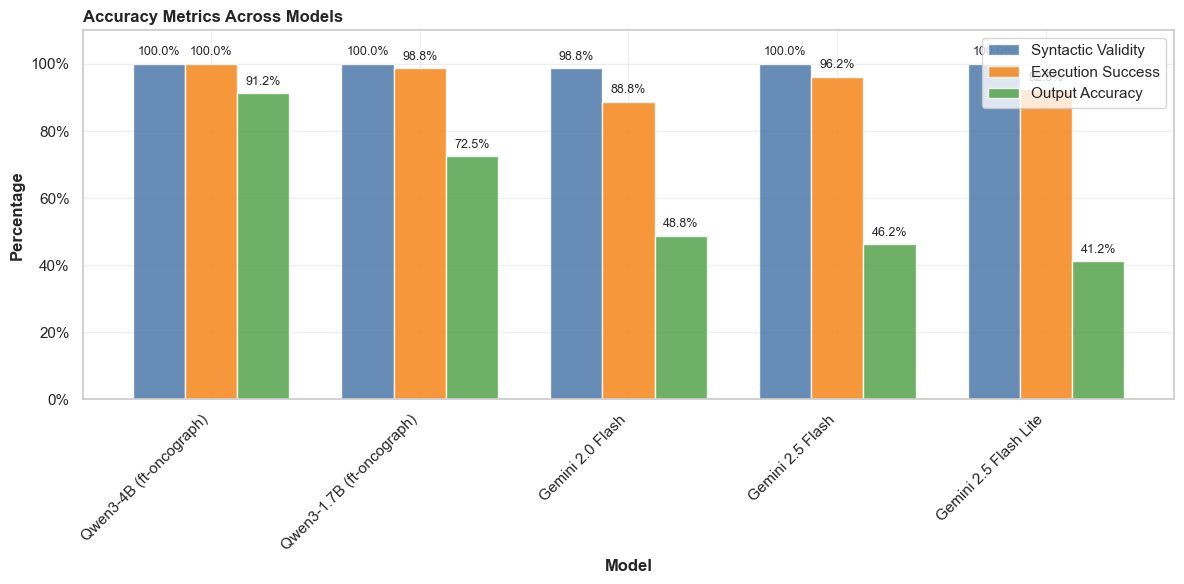

In [5]:
plot_accuracy_metrics(comparison_df, exclude_raw=EXCLUDE_BASE)

## 2) Qwen3-4B: before vs after fine-tuning

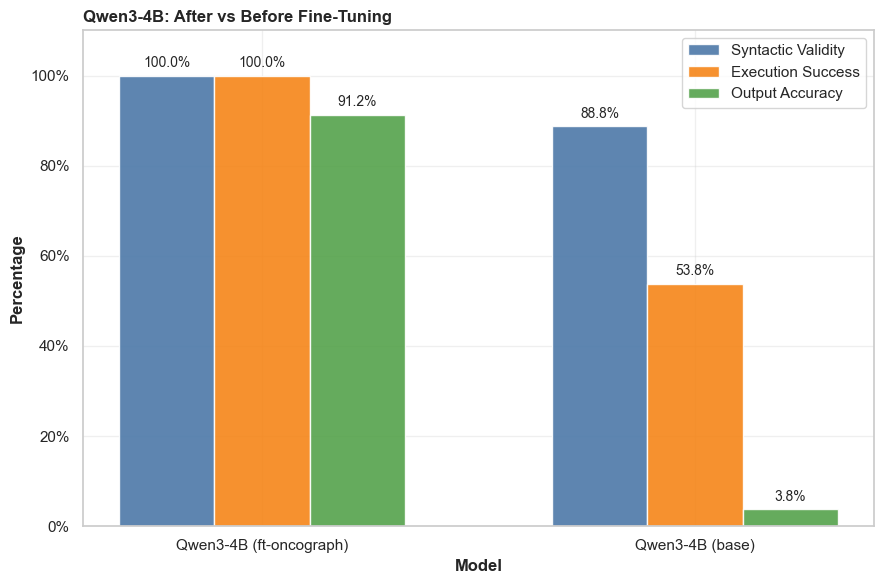

In [6]:
plot_qwen_before_after(comparison_df)

## 3) Overall output accuracy

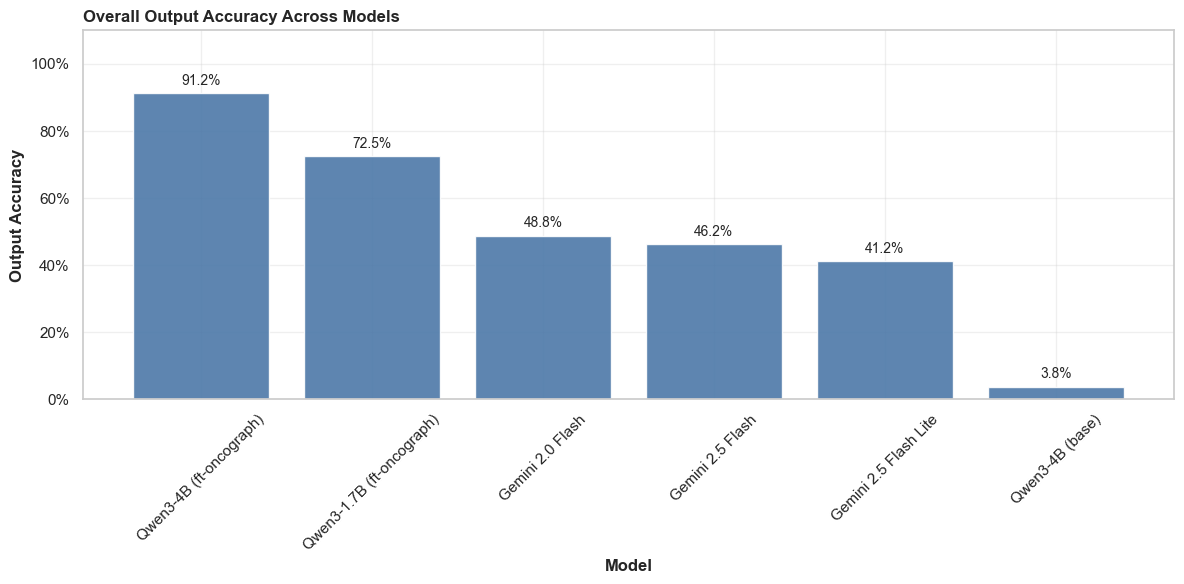

In [7]:
plot_overall_accuracy(comparison_df)

## 4) Latency across models
Note: Latency can be bottlenecked by non-optimized inference (e.g., free tiers),
and may not represent best-case performance for a given model.

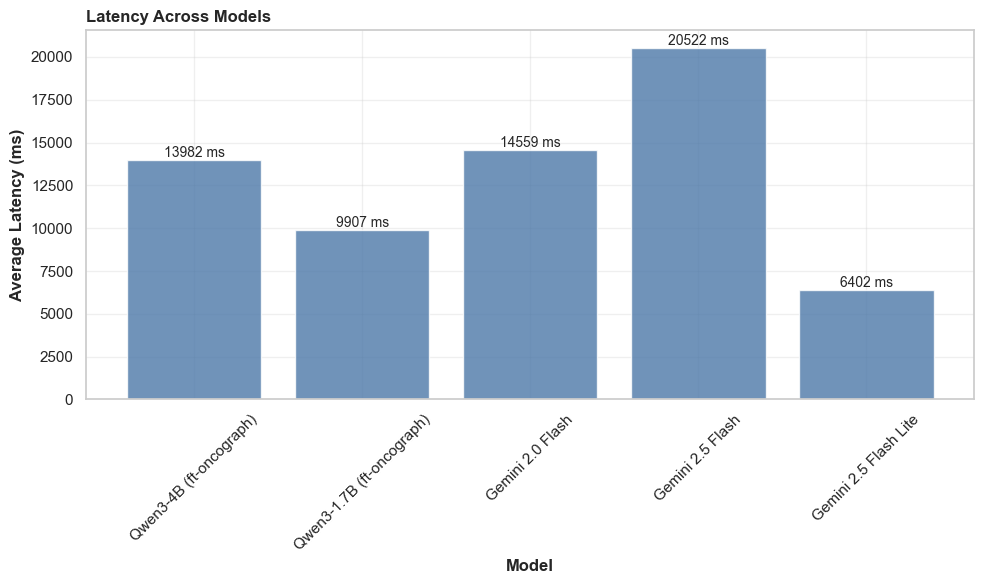

In [8]:
plot_latency(comparison_df, exclude_raw=EXCLUDE_BASE)

## 5) Token usage per query
Gemini models require significantly more input tokens to cover all schema details, edge cases, few shot examples, etc. This can lead to much higher costs.

Fine tuned models have this knowledge internalized.

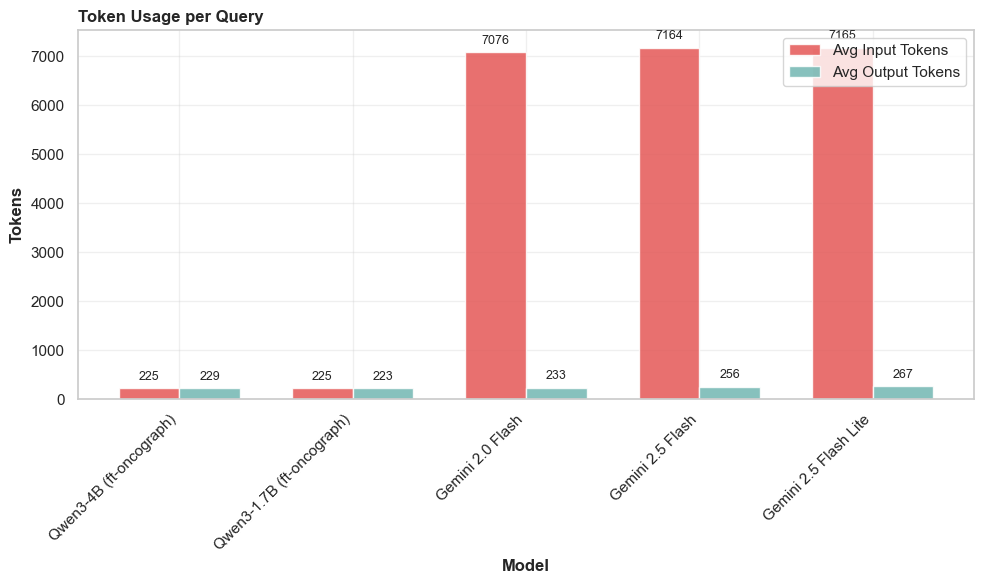

In [9]:
plot_token_usage(comparison_df, exclude_raw=EXCLUDE_BASE)

## 6) Accuracy vs latency trade-off
The most desirable region is top-left (higher accuracy, lower latency).

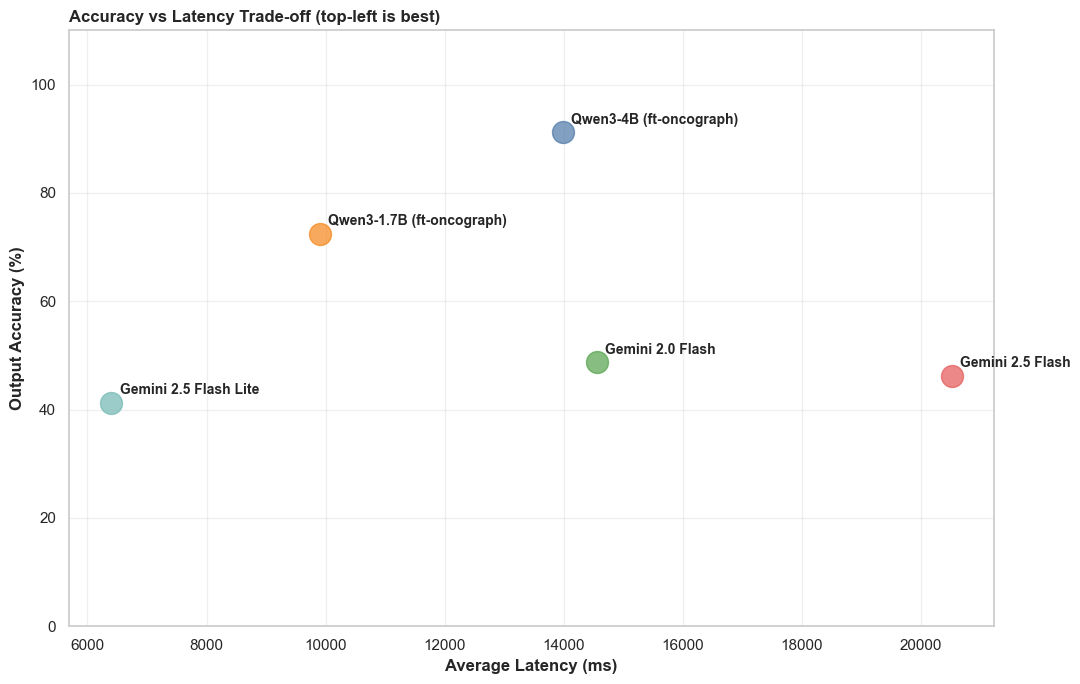

In [10]:
plot_accuracy_vs_latency(comparison_df, exclude_raw=EXCLUDE_BASE)

# 7) Model links

| Model Name                | Model ID                      | Link                                                                                  |
|----------------------------|-------------------------------|---------------------------------------------------------------------------------------|
| Qwen3-4B (ft-oncograph)    | qwen3-4b-ft-oncograph         | [Hugging Face](https://huggingface.co/ib565/qwen3-4b-ft-oncograph-lora-adapters)      |
| Qwen3-4B (base)            | Qwen3-4B-Instruct-2507-unsloth-bnb-4bit | [Hugging Face](https://huggingface.co/unsloth/Qwen3-4B-Instruct-2507-unsloth-bnb-4bit) |
| Qwen3-1.7B (ft-oncograph)  | qwen3-1.7b-ft-oncograph       | [Hugging Face](https://huggingface.co/ib565/qwen3-1.7b-ft-oncograph-lora-adapters)    |
| Qwen3-1.7B (base)          | Qwen3-1.7B-Instruct-2507-unsloth-bnb-4bit | [Hugging Face](https://huggingface.co/unsloth/Qwen3-1.7B-Instruct-2507-unsloth-bnb-4bit) |
| Gemini 2.0 Flash           | gemini-2.0-flash              | [Google Cloud](https://ai.google.dev/gemini-api/docs/models#gemini-2.0-flash)         |
| Gemini 2.5 Flash           | gemini-2.5-flash              | [Google Cloud](https://ai.google.dev/gemini-api/docs/models#gemini-2.5-flash)         |
| Gemini 2.5 Flash Lite      | gemini-2.5-flash-lite         | [Google Cloud](https://ai.google.dev/gemini-api/docs/models#gemini-2.5-flash-lite)    |